In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_excel("/content/drive/MyDrive/nlp/train.xlsx")
train.head()

,premise,hypothesis,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
2,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
3,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
4,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1


train dataset missing values treatment

In [ ]:

train_missing_values_count = train.isnull().sum() # we get the number of missing data points per column
print("Number of missing data points per column:\n")
print (train_missing_values_count)

Number of missing data points per column:

premise       0
hypothesis    0
label         0
dtype: int64


Duplicate values treatement

In [ ]:
train["is_duplicate"] = train.duplicated()
train[train["is_duplicate"]==True].count() 

premise         0
hypothesis      0
label           0
is_duplicate    0
dtype: int64

In [ ]:
train.drop_duplicates(keep=False, inplace=True, ignore_index=True)
train.drop("is_duplicate", axis=1, inplace=True) 
print("Number of data examples after dropping duplicates: {} \n".format(train.shape[0]))

Number of data examples after dropping duplicates: 6870 



In [ ]:
train.head()

,premise,hypothesis,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,2
2,you know they can't really defend themselves l...,They can't defend themselves because of their ...,0
3,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,2
4,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,1


 **Let's now visualize the distribution of class labels over the training data**

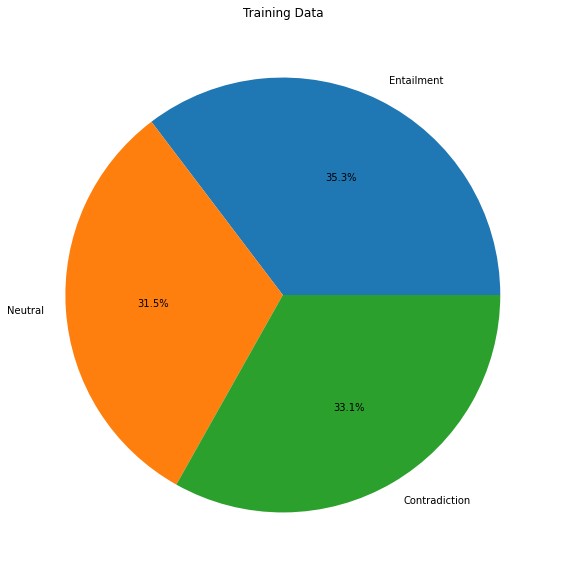

In [ ]:
import matplotlib.pyplot as plt
# check distribution of target classes in the augmented data
counts = train['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.title("Training Data")
plt.show()

**Split the Training Data**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, stratify=train.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
train.head()

,premise,hypothesis,label
0,"The policy succeeded, and I was fortunate to h...","Because the policy was a success, I was able t...",0
1,"But there's John â€and Miss Howard, surely th...",I'm sure Miss Howard is lying to us.,2
2,We make simulacra out of mandrakes--like the m...,The manicurist does great work.,1
3,A piece describes the Learning Channel's new w...,The Learning Channel has more shows for women ...,1
4,Charles Geveden has introduced legislation tha...,Charles Geveden insisted on keeping the supple...,2


In [ ]:
train.shape

(5496, 3)

In [ ]:
test.head()

,premise,hypothesis,label
0,"Very little indeed, answered Tuppence, and was...",Tuppence made Whittington uncomfortable and wa...,1
1,i'm not sure what the overnight low was,"I don't know how cold it got last night, but i...",1
2,These runs could cost far more than the value ...,The runs would be a bigger cost than the impro...,0
3,but but it is peaceful i mean it is relaxing t...,The time it takes is not very much.,1
4,and uh you know once you start up at the top a...,There needs to be a more transparent distribut...,1


In [ ]:
test.shape

(1374, 3)

**Implement BERT Model**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 28.5 MB/s 
     |████████████████████████████████| 163 kB 66.0 MB/s 
     |████████████████████████████████| 7.6 MB 60.7 MB/s 


In [ ]:
import os
import sys
from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product

In [ ]:
PRETRAINED_MODEL_TYPES = {}
PRETRAINED_MODEL_TYPES['bert'] = (TFBertModel, BertTokenizer, 'bert-base-multilingual-cased')
model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['bert']

tokenizer = BertTokenizer.from_pretrained(model_name) # Save the slow pretrained tokenizer
save_path = '.'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path) # Save the loaded tokenizer locally
tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False, strip_accents=False) # Load the fast tokenizer from saved file

tokenizer

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)

In [ ]:
# Handle Warnings: Optional
os.environ["WANDB_API_KEY"] = "0" # to silence warning
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices" # enable xla devices
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

np.random.seed(0) # For reproducibility

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

In [ ]:
train.head()

,premise,hypothesis,label
0,"The policy succeeded, and I was fortunate to h...","Because the policy was a success, I was able t...",0
1,"But there's John â€and Miss Howard, surely th...",I'm sure Miss Howard is lying to us.,2
2,We make simulacra out of mandrakes--like the m...,The manicurist does great work.,1
3,A piece describes the Learning Channel's new w...,The Learning Channel has more shows for women ...,1
4,Charles Geveden has introduced legislation tha...,Charles Geveden insisted on keeping the supple...,2


Configure Hyperparameter Settings and ENCODE

In [ ]:
# Configuration
EPOCHS = 3
BATCH_SIZE = 64 
MAX_LEN = 100
PATIENCE = 1
LEARNING_RATE = 1e-5

In [ ]:
def encode(df, tokenizer, max_len=50):
    pairs = df[['premise','hypothesis']].values.tolist()
    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()
    
    print ("Encoding...")
    enc_list = tokenizer.encode_batch(pairs)
    print ("Complete")

    input_word_ids = tf.ragged.constant([enc.ids for enc in enc_list], dtype=tf.int32)
    input_mask = tf.ragged.constant([enc.attention_mask for enc in enc_list], dtype=tf.int32) 
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in enc_list], dtype=tf.int32) 
   
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()}
    
    return inputs 

In [ ]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)
train_ids = train_input['input_word_ids'] 
train_mask = train_input['input_mask'] 
train_type = train_input['input_type_ids'] 
train_labels = train.label.values
print(train_input)

Encoding...
Complete
{'input_word_ids': <tf.Tensor: shape=(5496, 100), dtype=int32, numpy=
array([[  101, 10117, 14368, ...,     0,     0,     0],
       [  101, 16976, 11155, ...,     0,     0,     0],
       [  101, 12865, 13086, ...,     0,     0,     0],
       ...,
       [  101, 20593,   117, ...,     0,     0,     0],
       [  101,   138, 54181, ...,     0,     0,     0],
       [  101, 11065, 20737, ...,     0,     0,     0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(5496, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(5496, 100), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..

In [ ]:
validation_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)
validation_ids = validation_input['input_word_ids'] 
validation_mask = validation_input['input_mask'] 
validation_type = validation_input['input_type_ids'] 
validation_labels = test.label.values 

Encoding...
Complete


**Load and Process the Data in Batches**

In [ ]:
def create_dataset(features, labels, batch_size=BATCH_SIZE, validation=False):
    AUTO = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(len(features))
    if validation:
        dataset = dataset.batch(batch_size).prefetch(AUTO)
    else:
        dataset = dataset.repeat().batch(batch_size).prefetch(AUTO)
    return dataset

In [ ]:
training_data = create_dataset((train_ids, train_mask, train_type), train_labels, batch_size=BATCH_SIZE)
validation_data = create_dataset((validation_ids, validation_mask, validation_type), validation_labels, batch_size=BATCH_SIZE, validation=True)

In [ ]:
def build_model(model_name, model_class, max_len=50, add_input_type=False):
    tf.random.set_seed(123)

    encoder = model_class.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    if add_input_type:
        features = encoder([input_word_ids, input_mask, input_type_ids])[0] # shape=(batch_size, max_len, output_size)
    else:
        features = encoder([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, output_size)
    
    sequence = features[:,0,:]
   
    
    output = tf.keras.layers.Dense(3, activation="softmax")(sequence)  
    
    if add_input_type:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    else:
        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
        
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

    model = build_model(model_name, model_class, MAX_LEN, add_input_type=True)
    model.summary()

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 dense (Dense)                  (None, 3)            2307        ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                                  
Total params: 177,855,747
Trainable params: 177,855,747
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
checkpoint_filepath='bert_best_checkpoint.hdf5'
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

n_steps = int(train_ids.shape[0]/BATCH_SIZE)
train_history = model.fit(x=training_data, validation_data=validation_data, epochs=EPOCHS, verbose=1, steps_per_epoch=n_steps, callbacks=callbacks)

Epoch 1/3


85/85 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.4890
Epoch 1: val_loss improved from inf to 0.89526, saving model to bert_best_checkpoint.hdf5
85/85 [==============================] - 140s 1s/step - loss: 1.0028 - accuracy: 0.4890 - val_loss: 0.8953 - val_accuracy: 0.5924
Epoch 2/3
85/85 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.6449
Epoch 2: val_loss improved from 0.89526 to 0.83196, saving model to bert_best_checkpoint.hdf5
85/85 [==============================] - 114s 1s/step - loss: 0.7934 - accuracy: 0.6449 - val_loss: 0.8320 - val_accuracy: 0.6339
Epoch 3/3
85/85 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.7311
Epoch 3: val_loss did not improve from 0.83196
85/85 [==============================] - 110s 1s/step - loss: 0.6313 - accuracy: 0.7311 - val_loss: 0.8987 - val_accuracy: 0.6383
Epoch 3: early stopping


Plot Training and Validation Losses over all Epochs

In [ ]:
def plot_loss(history):
    ''' Plot loss history '''
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Average Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

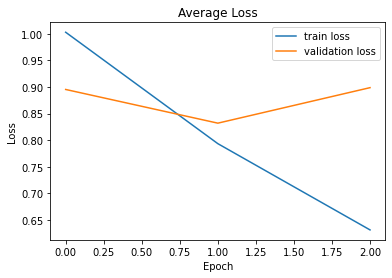

In [ ]:
plot_loss(train_history)

Plot Training and Validation Accuracies over all Epochs

In [ ]:
def plot_acc(history):
    ''' Plot accuracy history '''
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Average Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

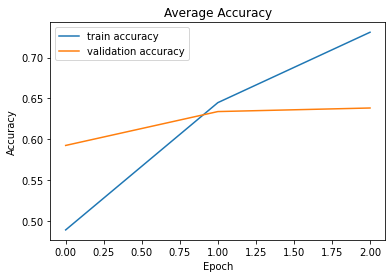

In [ ]:
plot_acc(train_history)

In [ ]:
outputfile = pd.read_excel("/content/drive/MyDrive/nlp/test.xlsx")
outputfile.head()

,premise,hypothesis
0,His family had lost a son and a daughter now.,The son and daughter had lost their father.
1,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...
2,how long has he been in his present position,What length of time has he held the current po...
3,Research and development is composed of,R&D is made up of.
4,Then I considered.,I refused to even consider it.


In [ ]:
test_input = encode(outputfile, tokenizer=tokenizer, max_len=MAX_LEN)
predictions = [np.argmax(i) for i in model.predict(test_input)]

Encoding...
Complete
92/92 [==============================] - 20s 200ms/step


In [ ]:
outputfile['predictions']=predictions

In [ ]:
outputfile.head()

,premise,hypothesis,predictions
0,His family had lost a son and a daughter now.,The son and daughter had lost their father.,0
1,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,1
2,how long has he been in his present position,What length of time has he held the current po...,0
3,Research and development is composed of,R&D is made up of.,0
4,Then I considered.,I refused to even consider it.,2


In [ ]:
outputfile.to_csv("outputfile.csv", index = False)